Welcome
-------


Welcome to the Apache Spark tutorial notebooks.

This very simple notebook is designed to test that your environment is setup correctly.

Please `Run All` cells. 

The notebook should run without errors and you should see a histogram plot at the end.

(You can also check the expected output [here](https://piotrszul.github.io/spark-tutorial/notebooks/0.1_Welcome.html))


#### Let's go


Let's check that there are some input data available:

In [1]:
%%sh

# All the test data sets are located in the `data` directory.
# You can preview them using unix command such as `cat`, `head`, `tail`,  `ls`,  etc. 
# in `shell` cells marked with the `%%sh` magic, e.g.: 

head -n 10 data/prince_by_machiavelli.txt

﻿The Project Gutenberg EBook of The Prince, by Nicolo Machiavelli

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: The Prince



Let's check if spark is available and what version are we using (should be 2.1+):

In [2]:
# `spark` is the main entry point for all spark related operations.
# It is an instance of SparkSession and pyspark automatically creates one for you.
# Another one is `sc` an instance of SparkContext, which is used for low lever RRD API.

spark.version

u'2.1.0'

Let's try to run a simple `Spark` program to compute the number of occurences of words in Machiavelli's "Prince", and display ten most frequent ones:

In [3]:
import operator
import re


# Here we use Spark RDD API to split a text file into invividual words, 
# to count the number of occurences of each word and to take top 10 most frequent words.

wordCountRDD = sc.textFile('data/prince_by_machiavelli.txt') \
        .flatMap(lambda line: re.split(r'[^a-z\-\']+', line.lower())) \
        .filter(lambda word: len(word) > 0 ) \
        .map(lambda word: (word, 1)) \
        .reduceByKey(operator.add)

# `take()` function takes the first n elements of an RDD 
# and returns them in a python `list` object, 
        
top10Words = wordCountRDD \
    .map(lambda (k,v):(v,k)) \
    .sortByKey(False) \
    .take(10)
    
    
# which can then be printed out
print(top10Words)

[(3108, u'the'), (2107, u'to'), (1935, u'and'), (1802, u'of'), (993, u'in'), (920, u'he'), (779, u'a'), (745, u'that'), (640, u'his'), (585, u'it')]


Spark SQL is a higer level API for structured data. The data are represented in `data frames` - table like object with columns and rows concenptully similar to `panadas` or `R` data fames.

Let's use Spark SQL to display a table with the 10 least frequent words:

In [4]:
# A data frame can be created from an RDD;
# schema defines the names (and types) of columns.

wordCountDF = spark.createDataFrame(wordCountRDD, schema = ['word', 'count'])

# it just means: sort by column `count` and take the first ten elements

bottom10Words = wordCountDF.sort('count').limit(10)

# `display` function can be used to display data frames (and also all other sorts of objects)
display(bottom10Words)

,word,count
0,secondly,1
1,surrounding,1
2,consolidated,1
3,comparatively,1
4,chill,1
5,prospering,1
6,calculate,1
7,attracted,1
8,similarity,1
9,popoli,1


Let's save the results to a csv file.

For the tutorial all the output files are saved in the `output` directory:

In [5]:
# data frames can be saved in many common 'table' formats, for example `csv`.
# the `mode='overwrite'` tells Spark to overwite the output file is it exists

wordCountDF.write.csv('output/prince-word-count.csv', mode='overwrite', header=True)

Let's preview the output:

In [6]:
%%sh 

# Same as with the input data sets, we can use the `%%sh` cells to preview the 
# files produced to the `output` directory.

# Please note that output we have produced above is actually a directory:

ls  -l output/prince-word-count.csv

# The `part-*` files inside contain the actual data.

echo
echo "Content:"

head -n 10 output/prince-word-count.csv/part-00000-*.csv 

total 120
-rw-r--r--  1 szu004  staff      0 10 Jul 09:01 _SUCCESS
-rw-r--r--  1 szu004  staff  28071 10 Jul 09:01 part-00000-37d5fa68-916f-4243-99f5-4615ed30faf0.csv
-rw-r--r--  1 szu004  staff  28953 10 Jul 09:01 part-00001-37d5fa68-916f-4243-99f5-4615ed30faf0.csv

Content:
word,count
pardon,2
dissolution,2
desirable,2
papacy,1
four,14
demanded,1
protest,1
thirst,1
consists,2


Finally we can use python `matplotlib` to visualise the result.

Let's plot the histogram of the distribution of word counts:

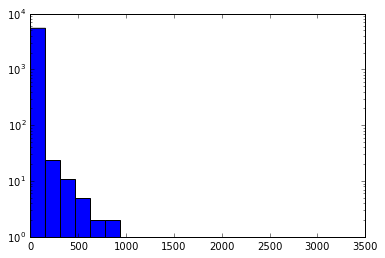

In [7]:
import matplotlib.pyplot as plt

# we can convert (small) Spark data frames to `pandas`
wordCountPDF = wordCountDF.toPandas()

# and then use pyplot (plt) to display the results
# Please note that we call `plt.close()` first - this is needed for Databricks 
# to start a new plot.

plt.close()
plt.hist(wordCountPDF['count'], bins = 20, log = True)
plt.show()
display()

You can now play around modifyging some pieces of the code.

When you are done and you are running off the local machine remeber **to close the notebook with `File/Close and Halt`**